# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Key steps**:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [2]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [3]:
print ("sigmoid([0, 2, 10, -10]) = " + str(sigmoid(np.array([0., 2., -2., 100.]))))

sigmoid([0, 2, 10, -10]) = [0.5        0.88079708 0.11920292 1.        ]


### Initializing parameters



In [4]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [5]:
dim = 3
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]]
b = 0.0


### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [6]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    eps = 1e-8
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A + eps)+(1-Y)*np.log(1-A + eps),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [7]:
w, b, X, Y = np.array([[1.],[-1.]]), 4., np.array([[1.,5.,-1.],[10.,0.,-3.2]]), np.array([[0,1,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.0027004 ]
 [0.02446984]]
db = [0.00151471]
cost = [0.00295536]


### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [8]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, sgd = False, adam = False, print_cost = False, batch_size = 30):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    dw, db = None, None
    beta_1, beta_2 = 0.9, 0.99
    m, v, t = np.zeros(2), np.zeros(2), np.zeros(2)
    
    eps = np.array([1e-8, 1e-8])
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        if sgd: 
            obj_ = np.random.choice(range(X.shape[1]), batch_size, replace = False)
            X_, Y_ = X[:, obj_], Y[obj_]
            
        else:
            X_, Y_ = X, Y
            
        grads, cost = propagate(w,b,X_,Y_)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        if not adam:
            w -=learning_rate*dw
            b -=learning_rate*db
            
        else:
            g = np.array([dw, db])
            m = beta_1 * m + (1 - beta_1) * g
            v = beta_2 * v + (1 - beta_2) * (g ** 2)
            m_est = m / (1 - beta_1 ** (i + 1)) 
            v_est = v / (1 - beta_2 ** (i + 1)) 

            delta = -learning_rate * m_est / (v_est ** 0.5 + eps)
            
            w += delta[0]
            b += delta[1]
        
        # Record the costs
        if i % 10 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. 

In [9]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [10]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]



Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [29]:
# model

def model(X_train, Y_train, X_test, Y_test, sgd = False, adam = False, num_iterations = 1000, learning_rate = 0.5,
          print_cost = False, batch_size = 30):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, sgd, adam,
                                        print_cost, batch_size)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    #print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    #print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"train accuracy": 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100,
         "test accuracy": 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100,
         "costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

##### Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


In [30]:
def learning_curves(X_train, Y_train, X_test, Y_test, optimize_name = 'GD', num_iterations = 1000, batch_size = 30):
    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
    x_data = [i for i in range(1, num_iterations + 1, 10)]
    plt.figure()
    data_accuracy = {}
    for lr_ in learning_rates:
        if optimize_name == 'GD':
            res_lt = model(X_train, Y_train, X_test, Y_test, learning_rate = lr_)
            
            plt.plot(x_data, res_lt['costs'], label = 'Loss function for learning_rate = {lt}'.format(lt = lr_))
            
            data_accuracy['learning_rate = {lt}'.format(lt = lr_)] = [res_lt['train accuracy'], res_lt['test accuracy']]
        
        elif optimize_name == 'SGD':
            res_lt = model(X_train, Y_train, X_test, Y_test, sgd = True, learning_rate = lr_, num_iterations = num_iterations,
                           batch_size = batch_size)
            
            plt.plot(x_data, res_lt['costs'], label = 'Loss function for learning_rate = {lt}'.format(lt = lr_))
            
            data_accuracy['learning_rate = {lt}'.format(lt = lr_)] = [res_lt['train accuracy'], res_lt['test accuracy']]
            
        else:
            res_lt = model(X_train, Y_train, X_test, Y_test, sgd = False, adam = True, learning_rate = lr_,
                           num_iterations = num_iterations)
            
            plt.plot(x_data, res_lt['costs'], label = 'Loss function for learning_rate = {lt}'.format(lt = lr_))
            
            data_accuracy['learning_rate = {lt}'.format(lt = lr_)] = [res_lt['train accuracy'], res_lt['test accuracy']]
            
    plt.xlabel('The iteration number')
    plt.ylabel('The value of the loss function')
    plt.title('Learning curves for {name}'.format(name = optimize_name))
    plt.legend()
    plt.show()
    
    res_accuracy = pd.DataFrame(data = data_accuracy)
    res_accuracy.index = ['Train accuracy', 'Test accuracy'] 
    return res_accuracy

In [13]:
import pandas as pd 

from sklearn.model_selection import train_test_split

In [14]:
data = pd.read_csv('bioresponse.csv')

In [15]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = data.drop(['Activity'], axis = 1)
Y = data['Activity']

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1234)

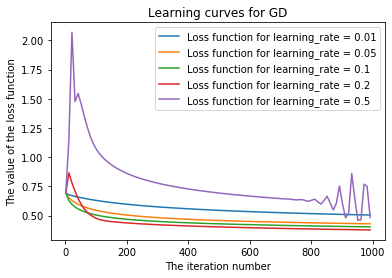

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,77.888375,81.656594,82.616424,83.753999,81.940988
Test accuracy,72.707889,75.906183,76.652452,76.439232,72.494670


In [31]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test))

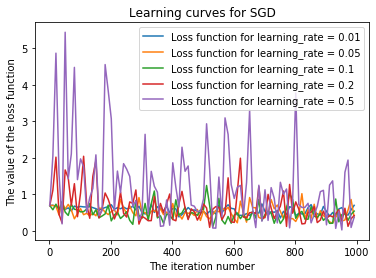

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,76.679701,80.199076,80.838962,72.307145,77.959474
Test accuracy,73.027719,76.226013,75.266525,68.550107,71.428571


In [37]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test), num_iterations = 1000,
                optimize_name = 'SGD', batch_size = 10)

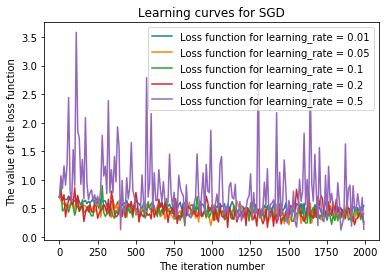

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,79.132599,81.692144,82.545325,81.905439,58.371845
Test accuracy,73.454158,76.012793,76.226013,74.946695,53.411514


In [33]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test), num_iterations = 1000,
                optimize_name = 'SGD', batch_size = 30)

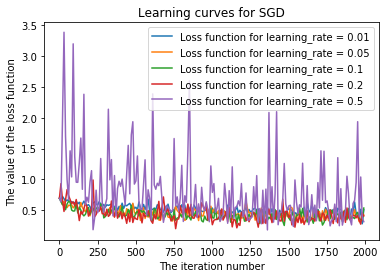

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,80.092428,81.976538,83.505155,84.145041,75.755421
Test accuracy,73.667377,76.119403,75.799574,76.545842,69.189765


In [34]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test), num_iterations = 1000,
                optimize_name = 'SGD', batch_size = 50)

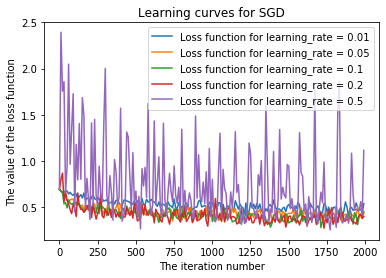

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,79.416993,81.869890,83.114113,84.180590,85.318166
Test accuracy,73.027719,76.972281,75.906183,76.759062,75.479744


In [35]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test), num_iterations = 1000,
                optimize_name = 'SGD', batch_size = 100)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Anaconda3\lib\site-packages\ipy

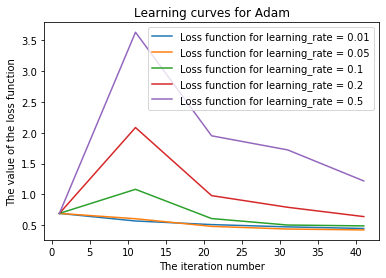

,learning_rate = 0.01,learning_rate = 0.05,learning_rate = 0.1,learning_rate = 0.2,learning_rate = 0.5
Train accuracy,81.407750,83.327408,83.682901,82.900818,83.647352
Test accuracy,73.667377,75.692964,76.972281,76.332623,76.865672


In [43]:
learning_curves(np.array(X_train).T, np.array(Y_train), np.array(X_test).T, np.array(Y_test), num_iterations = 50,
                optimize_name = 'Adam')

**Conclusion**

Thus, the most effective optimization algorithm was the Adam algorithm for 50 iterations with learning_rate = 0.1. In this case, the accuracy on the test data is 76.97%. It is worth noting that when optimizing Adam with more than 200 iterations, overfitting is observed.

Among the SGD modifications considered, the best one is with learning_rate = 0.05 and batch_size = 100. The accuracy is 76.97%.

The best GD option was GD with learning_rate = 0.1 for 1000 iterations. The accuracy for this method on the test data is 76.65%.

